<div style="text-align: center">
  <a href="https://www.aicrowd.com/challenges/rl-vi"><img alt="AIcrowd" src="https://images.aicrowd.com/raw_images/challenges/banner_file/754/3fc6598e270b9219e215.jpg"></a>
</div>

# What is the notebook about?

## Problem - Value Iteration
This problem deals with a grid world and stochastic actions. The tasks you have to do are:
- Complete the Environment
- Write code for value Iteration
- Visualize Results
- Explain the results

## How to use this notebook? 📝

- This is a shared template and any edits you make here will not be saved.**You
should make a copy in your own drive**. Click the "File" menu (top-left), then "Save a Copy in Drive". You will be working in your copy however you like.

- **Update the config parameters**. You can define the common variables here

Variable | Description
--- | ---
`AICROWD_DATASET_PATH` | Path to the file containing test data. This should be an absolute path.
`AICROWD_RESULTS_DIR` | Path to write the output to.
`AICROWD_ASSETS_DIR` | In case your notebook needs additional files (like model weights, etc.,), you can add them to a directory and specify the path to the directory here (please specify relative path). The contents of this directory will be sent to AIcrowd for evaluation.
`AICROWD_API_KEY` | In order to submit your code to AIcrowd, you need to provide your account's API key. This key is available at https://www.aicrowd.com/participants/me

- **Installing packages**. Please use the [Install packages 🗃](#install-packages-) section to install the packages

# Setup AIcrowd Utilities 🛠

We use this to bundle the files for submission and create a submission on AIcrowd. Do not edit this block.

In [ ]:
!pip install -U git+https://gitlab.aicrowd.com/aicrowd/aicrowd-cli.git@notebook-submission-v2 > /dev/null 

  Running command git clone -q https://gitlab.aicrowd.com/aicrowd/aicrowd-cli.git /tmp/pip-req-build-cjxwxvyz
  Running command git checkout -b notebook-submission-v2 --track origin/notebook-submission-v2
  Switched to a new branch 'notebook-submission-v2'
  Branch 'notebook-submission-v2' set up to track remote branch 'notebook-submission-v2' from 'origin'.


# AIcrowd Runtime Configuration 🧷

Define configuration parameters.

In [ ]:
import os

AICROWD_DATASET_PATH = os.getenv("DATASET_PATH", os.getcwd()+"/9db39385-0a4b-47db-8d20-fffb0480e47e_hw2_q2.zip")
AICROWD_RESULTS_DIR = os.getenv("OUTPUTS_DIR", "results")
API_KEY = "6b42b562b9eb39fe9d07fb070f706ef5" # Get your key from https://www.aicrowd.com/participants/me (ctrl + click the link)

In [ ]:
!aicrowd login --api-key $API_KEY
!aicrowd dataset download -c rl-vi

API Key valid
Saved API Key successfully!
9db39385-0a4b-47db-8d20-fffb0480e47e_hw2_q2.zip: 100% 3.08k/3.08k [00:00<00:00, 151kB/s]


In [ ]:
!unzip $AICROWD_DATASET_PATH

Archive:  /content/9db39385-0a4b-47db-8d20-fffb0480e47e_hw2_q2.zip
   creating: hw2_q2/
   creating: hw2_q2/targets/
  inflating: hw2_q2/targets/targets_0.npy  
   creating: hw2_q2/sample_results/
  inflating: hw2_q2/sample_results/sample_results_0.npy  
   creating: hw2_q2/inputs/
  inflating: hw2_q2/inputs/env_params_0.npy  


In [ ]:
DATASET_DIR = 'hw2_q2/'
!mkdir {DATASET_DIR}results/

# Install packages 🗃

Please add all package installations in this section

# Import packages 💻

In [ ]:
import numpy as np
import matplotlib.pyplot as plt 
import os
# ADD ANY IMPORTS YOU WANT HERE


# Task 0 - Complete the environment
You need to complete part of the environment which calculates the possible next states, their probabilities, and the reward.

In [ ]:
class GridEnv_HW2:
    def __init__(self, 
                 goal_location, 
                 action_stochasticity,
                 non_terminal_reward,
                 terminal_reward,
                 grey_in,
                 brown_in,
                 grey_out,
                 brown_out
                ):

        # Do not edit this section 
        self.action_stochasticity = action_stochasticity
        self.non_terminal_reward = non_terminal_reward
        self.terminal_reward = terminal_reward
        self.grid_size = [10, 10]

        # Index of the actions 
        self.actions = {'N': (-1, 0), 
                        'E': (0,1), 
                        'S': (1,0), 
                        'W': (0,-1)}
        
        # Do not worry about the names not matching the direction you expect
        # Think of them as generic names and use the mapping to get the action direction and stochasticity
        self.perpendicular_order = ['N', 'E', 'S', 'W']
        
        l = ['normal' for _ in range(self.grid_size[0]) ]
        self.grid = np.array([l for _ in range(self.grid_size[1]) ], dtype=object)

        self.grid[goal_location[0], goal_location[1]] = 'goal'
        self.goal_location = goal_location

        for gi in grey_in:
            self.grid[gi[0],gi[1]] = 'grey_in'
        for bi in brown_in:    
            self.grid[bi[0], bi[1]] = 'brown_in'

        self.grey_out = go = grey_out
        self.brown_out = bo = brown_out

        self.grid[go[0], go[1]] = 'grey_out'
        self.grid[bo[0], bo[1]] = 'brown_out'
        
        self.states_sanity_check()
    
    def states_sanity_check(self):
        """ Implement to prevent cases where the goal gets overwritten etc """
        pass

    def visualize_grid(self):
        pass

    def _out_of_grid(self, state):
        if state[0] < 0 or state[1] < 0:
            return True
        elif state[0] > self.grid_size[0] - 1:
            return True
        elif state[1] > self.grid_size[1] - 1:
            return True
        else:
            return False

    def _grid_state(self, state):
        return self.grid[state[0], state[1]]        
        
    def get_transition_probabilites_and_reward(self, state, action):
        """ 
        Returns the probabiltity of all possible transitions for the given action in the form:
        A list of tuples of (next_state, probability, reward)
        Note that based on number of state and action there can be many different next states
        Unless the state is All the probabilities of next states should add up to 1
        """

        grid_state = self._grid_state(state)
        
        if grid_state == 'goal':
            return [(self.goal_location, 1.0, 0.0)]
        elif grid_state == 'grey_in':
            return [(self.grey_out, 1.0, self.non_terminal_reward)]
        elif grid_state == 'brown_in':
            return [(self.brown_out, 1.0, self.non_terminal_reward)]
        
        direction = self.actions.get(action, None)
        if direction is None:
            raise ValueError("Invalid action %s , please select among" % action, list(self.actions.keys()))

        nextstates_prob_rews = []

        # TASK 0 - Complete the environment

        # ADD YOUR CODE BELOW - DO NOT EDIT ABOVE THIS LINE
        action_order = []
        for i in range(self.perpendicular_order.index(action),len(self.perpendicular_order)):
          action_order.append(self.perpendicular_order[i])
        for i in range(0, self.perpendicular_order.index(action)):
          action_order.append(self.perpendicular_order[i])

        row_action_probab = dict()
        for i in range(len(action_order)):
          row_action_probab[action_order[i]] = self.action_stochasticity[i]

        for move in self.perpendicular_order:

          probab = row_action_probab[move]
          next_state = []
          next_state.append(state.copy()[0] + self.actions.get(move, None)[0])
          next_state.append(state.copy()[1] + self.actions.get(move, None)[1])

          if self._out_of_grid(next_state):
            next_state = state.copy()
          else:
            pass

          next_grid_state = self._grid_state(next_state)
          if next_grid_state == 'goal':
            next_reward = self.terminal_reward
          else:
            next_reward = self.non_terminal_rewardp
          nextstates_prob_rews.append((next_state, probab, next_reward))


        # Hints: 
            # Get access to all actions with self.actions
            # Use self.action_stochasticity for the probabilities of the other action
                # The array will have probabilities for [0, 90, 180, -90] degrees
                # So self.action_stochasticity = [0.8, 0.1, 0.0, 0.1] means 0.8 for forward and 0.1 for left and right
            # Remember that you need to return a list of tuples with the form (next_state, probability, reward)
            # If you have 3 possible next states, you should return [(ns1, p1, r1), (ns2, p2, r2), (ns3, p3, r3)]
            # Use the helper function self._out_of_grid to check if any state is outside the grid
            
        # Important Note:
            # Do not hard code any state locations, they may be changed in the submissions


        # DO NOT EDIT BELOW THIS LINE

        return nextstates_prob_rews

# Question - When do you decide to stop value iteration 
Modify this cell and add you answer

# Task 1

## a) Implement Value iteration

In [ ]:
def value_iter(env):
  value_grid = np.zeros((10, 10)) # Marked as J(s) in the homework pdf
  policy = np.zeros((10, 10), np.int32) # Marked as pi(s) in homework pdf

  value_grids = [] # Store all the J(s) grids at every iteration in this list
  policies = []  # Store all the pi(s) grids at every iteration in this list

  # ADD YOUR CODE BELOW - DO NOT EDIT ABOVE THIS LINE
  value_grids.append(value_grid.copy())
  policies.append(policy.copy())
  while True:
    error = 0
    for i in range(10):
      for j in range(10):
        current_J = value_grid[i,j]
        values = []
        for move in env.perpendicular_order:
          new_J = 0
          for st_prob_rew in env.get_transition_probabilites_and_reward([i,j],move):
            new_J += (st_prob_rew[2] + value_grid[st_prob_rew[0][0], st_prob_rew[0][1]]) * st_prob_rew[1]
          values.append(new_J)
        value_grid[i,j] = max(values)
        policy[i,j] = env.perpendicular_order.index(env.perpendicular_order[values.index(max(values))])
        error = max(error, abs(value_grid[i,j]-current_J))
    value_grids.append(value_grid.copy())
    policies.append(policy.copy())
    if error < 1e-8:
      break

  # Important Note: 
  # The action names are strings but the expected output is an integer array
  # To get the corresponding mapping of integer values use -> env.perpendicular_order
  # So if your action is 'E' 
  # Your result would be: env.perpendicular_order.index('E') -> 1
  

  # DO NOT EDIT BELOW THIS LINE
  results = {"value_grid": value_grid, "pi_s": policy}
  return results, value_grids, policies

## Here is an example of what the "results" output from value_iter function should look like

**The numpy array may look different from the image given in the pdf because the origins are different, do not worry about this, use indexing and directions as providided by the env class (env.actions) and do not hard code anything.**

Ofcourse, it won't be all zeros

``` python 
{'value_grid': array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
  'pi_s': array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)}
```

In [ ]:
# DO NOT EDIT THIS CELL, DURING EVALUATION THE DATASET DIR WILL CHANGE
!mkdir $AICROWD_RESULTS_DIR
input_dir = os.path.join(DATASET_DIR, 'inputs')
for params_file in os.listdir(input_dir):
  kwargs = np.load(os.path.join(input_dir, params_file), allow_pickle=True).item()
  env = GridEnv_HW2(**kwargs)
  results, value_grids, policies = value_iter(env)
  idx = params_file.split('_')[-1][:-4]
  np.save(os.path.join(AICROWD_RESULTS_DIR, 'results_' + idx), results)

#Task 2 - The value iteration loop goes to infinity (refer the pseudocode given above), so when would you stop your value iteration?

I will stop the value iteration when current maximum value of the $||J_{i+1}(s) - J_i(s)||$ for all states is below the 10*-8 value.

# Task 3- Plot graph of $||J_{i+1}(s) - J_i(s)||$
An example plot code is provided below, but you can change it if you want

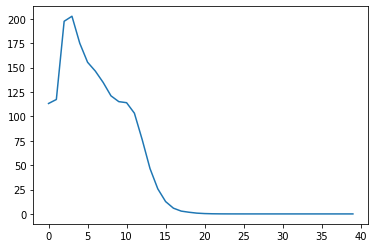

In [ ]:
import matplotlib.pyplot as plt
diffs = []
for ii in range(len(value_grids)-1):
    diff = np.linalg.norm(value_grids[ii+1] - value_grids[ii]) 
    diffs.append(diff)
plt.plot(diffs)

# Task 4 - Show $J(s)$ and $pi(s)$ after 10, 25 and final iteration. 

J(s) after 10 iteration


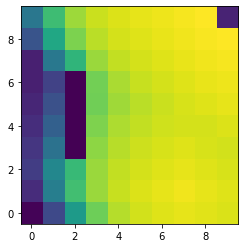


Pi(s) after 10 iteration
Thick-Blue: North, Light-Blue: East, Green: South, Yellow: West


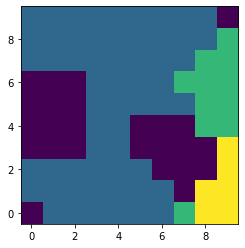


J(s) after 25 iteration


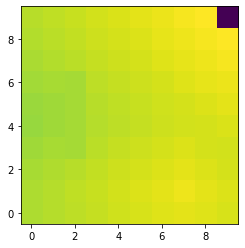


Pi(s) after 25 iteration
Thick-Blue: North, Light-Blue: East, Green: South, Yellow: West


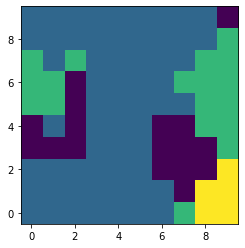


J(s) after 40 iteration


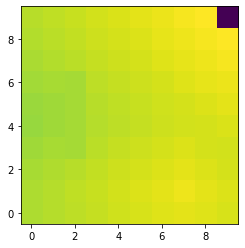


Pi(s) after 40 iteration
Thick-Blue: North, Light-Blue: East, Green: South, Yellow: West


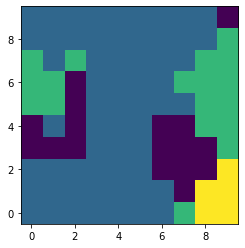

In [ ]:
# Use any visualization code you want to show the value and policies

# After 10 iteration
print('J(s) after 10 iteration')
plt.imshow(value_grids[10], origin='lower')
plt.show()
print()

print('Pi(s) after 10 iteration')
print('Thick-Blue: North, Light-Blue: East, Green: South, Yellow: West')
plt.imshow(policies[10], origin='lower')
plt.show()
print()

# After 25 iteration
print('J(s) after 25 iteration')
plt.imshow(value_grids[25], origin='lower')
plt.show()
print()

print('Pi(s) after 25 iteration')
print('Thick-Blue: North, Light-Blue: East, Green: South, Yellow: West')
plt.imshow(policies[25], origin='lower')
plt.show()
print()

# After Final iteration
print('J(s) after', len(value_grids)-1, 'iteration')
plt.imshow(value_grids[len(value_grids)-1], origin='lower')
plt.show()
print()

print('Pi(s) after', len(value_grids)-1, 'iteration')
print('Thick-Blue: North, Light-Blue: East, Green: South, Yellow: West')
plt.imshow(policies[len(value_grids)-1], origin='lower')
plt.show()
print()

# 

# Task 5 - Consider a new gridworld (GridWorld-2) as shown Figure 2 (GridWorld-2 differ from GridWorld-1 only in the position of the “Goal” state). Compare and contrast the behavior of J and greedy policy π for GridWorld-1 and GridWorld-2


Grid World 1 Policy:

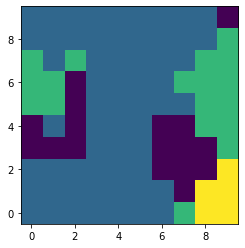

GridWorld 2 Policy:

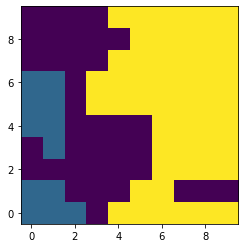

By observation the policy that we got from the value iteration process is pretty simple. when we are close to the quicksand and it's out is away from the goal, we move away from the quick sand. when the quicksand has a easy way out near the goal state, then we try to attain the quicksand state. 

In both the gridworld the quicksand that has it's out state near the goal has it's quicksand farther away from the goal, policy attracts us to the quicksand which leads us near the goal and viseversa. 

# Submit to AIcrowd 🚀

In [ ]:
!DATASET_PATH=$AICROWD_DATASET_PATH aicrowd notebook submit -c rl-vi -a assets

Using notebook: /content/Copy%20of%20my%20IITM_RL_VI_v1.ipynb for submission...
Mounting Google Drive 💾
Your Google Drive will be mounted to access the colab notebook
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g5mvXULFr1OyswaRrfW9jsvTUN4G06OaUL72C0qpUrCQQGucM_StUk
Mounted at /content/drive
Scrubbing API keys from the notebook...
Validating the submission...
Executing install.ipynb...
[NbConvertApp] Converti